# MNIST Handwritten Digit Classification using Bayes Classifier
# Aadhar Dutta 2K18/IT/001
# Dhruv Yadav 2K18/SE/056

## Imports

In [ ]:
# importing necessary libraries

import os
import seaborn as sns
import cv2
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import math
import sklearn
from sklearn import datasets, metrics, model_selection
from sklearn.metrics import classification_report

## Loading Data

In [ ]:
# functions of load images and labels from the dataset.

def load_images(filename):
    
    with gzip.open(filename, 'r') as f:
        
        magic_number = int.from_bytes(f.read(4), 'big')
        image_count = int.from_bytes(f.read(4), 'big')
        row_count = int.from_bytes(f.read(4), 'big')
        column_count = int.from_bytes(f.read(4), 'big')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        
        return images


def load_labels(filename):
    
    with gzip.open(filename, 'r') as f:

        magic_number = int.from_bytes(f.read(4), 'big')
        label_count = int.from_bytes(f.read(4), 'big')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
        return labels

In [ ]:
# filenames

train_image_file = 'train-images-idx3-ubyte.gz'
train_label_file = 'train-labels-idx1-ubyte.gz'
test_image_file = 't10k-images-idx3-ubyte.gz'
test_label_file = 't10k-labels-idx1-ubyte.gz'

In [ ]:
# loading the datset

train_images = load_images(train_image_file)
train_labels = load_labels(train_label_file)
test_images = load_images(test_image_file)
test_labels = load_labels(test_label_file)

## Data Visualization And Preprocessing

In [ ]:
# exploring the dataset

print("train-images-size : ", train_images.shape)
print("test-images-size : ", test_images.shape)
print("train-labels-size : ", train_labels.shape)
print("test-labels-size : ", test_labels.shape)
print("Dimensions of a single image : ", train_images[0].shape)

train-images-size :  (60000, 28, 28)
test-images-size :  (10000, 28, 28)
train-labels-size :  (60000,)
test-labels-size :  (10000,)
Dimensions of a single image :  (28, 28)


(0, 3, 5, 7)

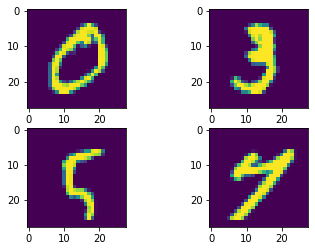

In [ ]:
# displaying some images and their labels from the training dataset.

image = np.asarray(train_images[1]).squeeze()
plt.subplot(221)
plt.imshow(image)

image = np.asarray(train_images[10]).squeeze()
plt.subplot(222)
plt.imshow(image)

image = np.asarray(train_images[100]).squeeze()
plt.subplot(223)
plt.imshow(image)

image = np.asarray(train_images[1001]).squeeze()
plt.subplot(224)
plt.imshow(image)

train_labels[1], train_labels[10], train_labels[100], train_labels[1001]

In [ ]:
# selecting digits in required_labels and then preparing data of those digits

def generate_data(images, labels, required_labels):
    
    X_images = []
    X_labels = []
    
    for current_label in required_labels:
        
        indices = np.where(labels == current_label)
        
        for idx in indices[0]:
            X_images.append(images[idx])
            X_labels.append(labels[idx])
    
    X_images = np.array(X_images)
    X_labels = np.array(X_labels)
    
    shuffler = np.random.permutation(len(X_labels))
    images_shuffled = X_images[shuffler]
    labels_shuffled = X_labels[shuffler]
    images_shuffled = images_shuffled.reshape(images_shuffled.shape[0],28*28)
    
    return images_shuffled, labels_shuffled

In [ ]:
# helper function
# counts the no of zeros in a feature row

def count_zero(row):
    
    freq = 0
    
    for i in row:
        if i == 0:
            freq += 1
    return freq

In [ ]:
# eliminating columns of features which have more than 99%  '0' in them. These features are useless and removing them 
# increased the accuracy by a large margain. 
# These features are mostly present in the leftmost and rightmost part of the image.

def eliminate_features(X_train, X_test,threshold):
    
    n = X_train.shape[0]
    m = X_test.shape[0]

    combined_images = []

    for i in range(n):
        combined_images.append(X_train[i])

    for i in range(m):
        combined_images.append(X_test[i])

    combined_images = np.array(combined_images)
    
    images = []
    
    for i in range(combined_images.shape[1]):
        row = combined_images[:, i]
        freq = count_zero(row)
        if (freq / combined_images.shape[0])*100 < threshold:
            images.append(row)
            
    images = np.array(images)
    images = images.T

    X_train = images[:n]
    X_test = images[n:n + m]
    
    return X_train, X_test

In [ ]:
# used to split dataset into train, test set by using generate_data function and eliminate_features function

def generate_test_train_data(train_images, train_labels, test_images, test_labels, required_labels):
    
    X_train, Y_train = generate_data(train_images, train_labels, required_labels)

    X_test, Y_test = generate_data(test_images, test_labels, required_labels)
    
    print("X_train shape before feature elimination : ", X_train.shape)
    print("X_test shape before feature elimination : ", X_test.shape)
    
    X_train, X_test = eliminate_features(X_train,X_test,99)
    
    print()
    print()
    
    print("X_train shape after feature elimination : ", X_train.shape)
    print("X_test shape after feature elimination : ", X_test.shape)
    print()
    print()
    print("Y_train shape : ", Y_train.shape)
    print("Y_test shape : ", Y_test.shape)
    
    
    return X_train, Y_train, X_test, Y_test

## Splitting Data Into Test, Train Set

In [ ]:
required_labels = [0,1]

In [ ]:
X_train, Y_train, X_test, Y_test = generate_test_train_data(train_images, train_labels, test_images, test_labels, required_labels)

X_train shape before feature elimination :  (12665, 784)
X_test shape before feature elimination :  (2115, 784)


X_train shape after feature elimination :  (12665, 411)
X_test shape after feature elimination :  (2115, 411)


Y_train shape :  (12665,)
Y_test shape :  (2115,)


In [ ]:
classes,counts = np.unique(Y_test,return_counts=True)
print("In the testing Dataset")
print("Number of data points with class ", classes[0], " : ",counts[0])
print("Number of data points with class ", classes[1], " : ",counts[1])

print()
print()
classes,counts = np.unique(Y_train,return_counts=True)
print("In the training Dataset")
print("Number of data points with class ", classes[0], " : ",counts[0])
print("Number of data points with class ", classes[1], " : ",counts[1])

In the testing Dataset
Number of data points with class  0  :  980
Number of data points with class  1  :  1135


In the training Dataset
Number of data points with class  0  :  5923
Number of data points with class  1  :  6742


## Gaussian Naive Bayes Classifier (A)

In [ ]:
# fitting the model.

clf = GaussianNB()
clf.fit(X_train, Y_train)

GaussianNB()

In [ ]:
# predictions 

y_pred = clf.predict(X_test)

## Evaluation Metrics

#### Confusion Matrix

In [ ]:
matrix = (confusion_matrix(Y_test,y_pred))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        print(matrix[i][j],end = "     ")
    print()

979     1     
21     1114     


CONFUSION MATRIX


Text(141.0, 0.5, 'Predicted class value')

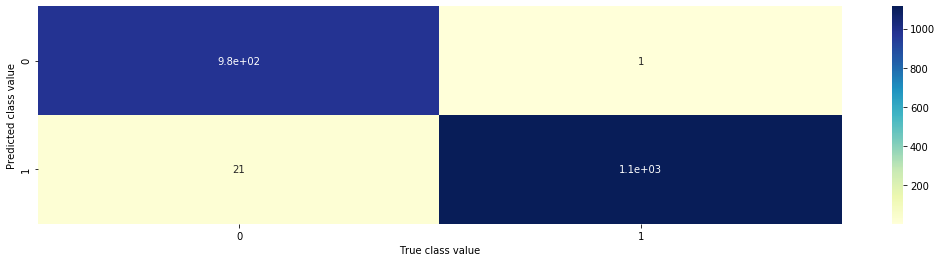

In [ ]:
#Print Confusion Matrix

print("CONFUSION MATRIX")
plt.figure(figsize=(18,4))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('True class value')
plt.ylabel('Predicted class value')

#### Classification Accuracy (B)

In [ ]:
# calculates classification accuracy

def score(matrix):
    
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy*100

In [ ]:
print("Accuracy of the model is : ", score(matrix), " %")

Accuracy of the model is :  98.95981087470449  %


#### Classification Report

In [ ]:
report = classification_report(Y_test, y_pred, target_names=["Digit 0","Digit 1"])
print(report)

              precision    recall  f1-score   support

     Digit 0       0.98      1.00      0.99       980
     Digit 1       1.00      0.98      0.99      1135

    accuracy                           0.99      2115
   macro avg       0.99      0.99      0.99      2115
weighted avg       0.99      0.99      0.99      2115



#### ROC Curve Between FAR Vs GAR

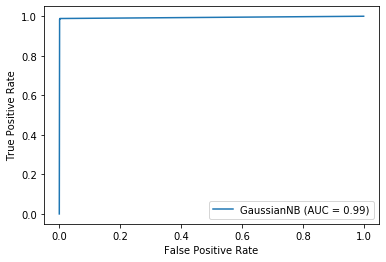

In [ ]:
metrics.plot_roc_curve(clf, X_test, Y_test)
plt.show()

# Classification For Digit 3 And Digit 8





## Splitting Data into Test, Train Set

In [ ]:
required_labels = [3,8]

In [ ]:
X_train, Y_train, X_test, Y_test = generate_test_train_data(train_images, train_labels, test_images, test_labels, required_labels)

X_train shape before feature elimination :  (11982, 784)
X_test shape before feature elimination :  (1984, 784)


X_train shape after feature elimination :  (11982, 457)
X_test shape after feature elimination :  (1984, 457)


Y_train shape :  (11982,)
Y_test shape :  (1984,)


In [ ]:
classes,counts = np.unique(Y_test,return_counts=True)
print("In the testing Dataset")
print("Number of data points with class ", classes[0], " : ",counts[0])
print("Number of data points with class ", classes[1], " : ",counts[1])

print()
print()
classes,counts = np.unique(Y_train,return_counts=True)
print("In the training Dataset")
print("Number of data points with class ", classes[0], " : ",counts[0])
print("Number of data points with class ", classes[1], " : ",counts[1])

In the testing Dataset
Number of data points with class  3  :  1010
Number of data points with class  8  :  974


In the training Dataset
Number of data points with class  3  :  6131
Number of data points with class  8  :  5851


## Gaussian Naive Bayes Classifier (D)

In [ ]:
# fitting the model.

clfs = GaussianNB()
clfs.fit(X_train, Y_train)

GaussianNB()

In [ ]:
# predictions 

y_pred = clfs.predict(X_test)
y_pred

array([3, 8, 3, ..., 8, 8, 3], dtype=uint8)

## Evaluation Metrics

#### Confusion Matrix

In [ ]:
matrix = (confusion_matrix(Y_test,y_pred))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        print(matrix[i][j],end = "     ")
    print()

892     118     
54     920     


CONFUSION MATRIX


Text(141.0, 0.5, 'Predicted class value')

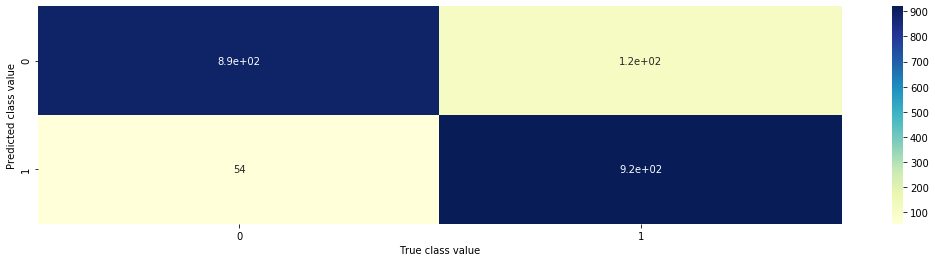

In [ ]:
#Print Confusion Matrix

print("CONFUSION MATRIX")
plt.figure(figsize=(18,4))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('True class value')
plt.ylabel('Predicted class value')

#### Classification Accuracy (D)

In [ ]:
print("Accuracy of the model is : ", score(matrix), " %")

Accuracy of the model is :  91.33064516129032  %


#### Classification Report

In [ ]:
report = classification_report(Y_test, y_pred, target_names=["Digit 3","Digit 8"])
print(report)

              precision    recall  f1-score   support

     Digit 3       0.94      0.88      0.91      1010
     Digit 8       0.89      0.94      0.91       974

    accuracy                           0.91      1984
   macro avg       0.91      0.91      0.91      1984
weighted avg       0.92      0.91      0.91      1984



#### ROC Curve Between FAR Vs GAR (D)

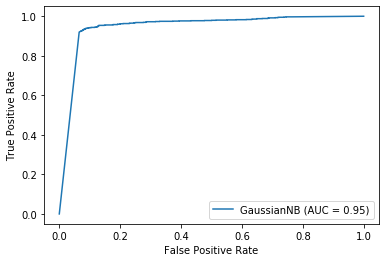

In [ ]:
metrics.plot_roc_curve(clfs, X_test, Y_test)
plt.show()

###### END OF ASSIGNMENT